## X Learner

### <b><span style='color:#686dec'>Background</span></b>

There are various approaches to estimating the `uplift`
- Our aim will be to replicate the `x-learner` (Two independent Model) approach to uplift modeling using only `sklearn`, the appoach itself is not implemented in `scikit-uplift` so we need to realise it!
- This is desired to show an understanding of what the approach actually involves, rather than using ready modules

In [1]:
! pip install scikit-uplift -U -qqq

 System commands are not supported in Juno (yet)


### <b><span style='color:#686dec'>Read Dataset</span></b>

- We'll be using the `fetch_x5_clients` dataset. `df_train` contains the treatment & target vectors.
- `df_clients` contains more `client_id` than treatment information, so we need to merge and keep only those clients for whom we have treatment data

`control` and `target` groups are:
 - The `control` group contains clients not targeted (`treatment_flg` = 0)
 - The `target` group contains clients targeted (`treatment_flag` = 1)

<br>

In [2]:
import pandas as pd

df_clients = pd.read_csv('fetch_x5_clients.csv')
df_train = pd.read_csv('fetch_x5_train.csv')

df_clients.head()

client_id     first_issue_date    first_redeem_date  age gender
0  000012768d  2017-08-05 15:40:48  2018-01-04 19:30:07   45      U
1  000036f903  2017-04-10 13:54:23  2017-04-23 12:37:56   72      F
2  000048b7a6  2018-12-15 13:33:11                  NaN   68      F
3  000073194a  2017-05-23 12:56:14  2017-11-24 11:18:01   60      F
4  00007c7133  2017-05-22 16:17:08  2018-12-31 17:17:33   67      U

In [3]:
df_train.head()

client_id  treatment_flg  target
0  000012768d              0       1
1  000036f903              1       1
2  00010925a5              1       1
3  0001f552b0              1       1
4  00020e7b18              1       1

In [4]:
print(df_train.isna().sum())
print('')
print(df_clients.isna().sum())

client_id        0
treatment_flg    0
target           0
dtype: int64

client_id                0
first_issue_date         0
first_redeem_date    35469
age                      0
gender                   0
dtype: int64


In [5]:
df_clients = df_clients.dropna()
df_clients.shape

(364693, 5)

In [6]:
df_features = df_train.merge(df_clients,on='client_id')
df_features.index = df_features['client_id']
del df_features['client_id']

In [7]:
df_features

treatment_flg  target     first_issue_date    first_redeem_date  \
client_id                                                                     
000012768d              0       1  2017-08-05 15:40:48  2018-01-04 19:30:07   
000036f903              1       1  2017-04-10 13:54:23  2017-04-23 12:37:56   
00010925a5              1       1  2018-07-24 16:21:29  2018-09-14 16:12:49   
0001f552b0              1       1  2017-06-30 19:20:38  2018-08-28 12:59:45   
00020e7b18              1       1  2017-11-27 11:41:45  2018-01-10 17:50:05   
...                   ...     ...                  ...                  ...   
fffd8c9d7d              1       0  2018-02-20 13:40:04  2018-06-30 20:02:51   
fffe0abb97              0       0  2017-11-27 08:56:54  2018-02-11 09:26:08   
fffe0ed719              0       1  2017-09-15 08:53:24  2017-12-12 14:50:12   
fffea1204c              0       1  2018-01-31 16:59:37  2018-03-12 17:02:27   
fffff6ce77              0       1  2017-08-03 20:25:12  2017-08-26 16:41:41   

            age gender  
client_id               
000012768d   45      U  
000036f903   72      F  
00010925a5   83      U  
0001f552b0   33      F  
00020e7b18   73      U  
...         ...    ...  
fffd8c9d7d   48      F  
fffe0abb97   35      F  
fffe0ed719   69      U  
fffea1204c   73      F  
fffff6ce77   42      U  

[182493 rows x 6 columns]

### <b><span style='color:#686dec'>Feature Preparation</span></b>

- We'll be using basic features, similar to the [uplift notebook](https://shtrausslearning.github.io/notebooks/course_recsys/Uplift_Modeling).
- We'll be using `GradientBoosting` so we'll need to convert categorical data into numeric.

In [8]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
df_features['gender'] = encoder.fit_transform(df_features['gender'])

In [9]:
# feature extraction
df_features['first_issue_time'] = (pd.to_datetime(df_features['first_issue_date'])- pd.Timestamp('1970-01-01')) // pd.Timedelta('1s')
df_features['first_redeem_time'] = (pd.to_datetime(df_features['first_redeem_date']) - pd.Timestamp('1970-01-01')) // pd.Timedelta('1s')
df_features['issue_redeem_delay'] = df_features['first_redeem_time'] - df_features['first_issue_time']
df_features = df_features.drop(['first_issue_date', 'first_redeem_date'], axis=1)

df_features.head(2)

treatment_flg  target  age  gender  first_issue_time  \
client_id                                                          
000012768d              0       1   45       2        1501947648   
000036f903              1       1   72       0        1491832463   

            first_redeem_time  issue_redeem_delay  
client_id                                          
000012768d         1515094207            13146559  
000036f903         1492951076             1118613

### <b><span style='color:#686dec'>Train/Test Splitting</span></b>

We split the dataset into two parts, we'll be evaluating the `uplift` on training and the generalised set

In [10]:
"""

Train / Test Splitting

"""

y = "target"
T = "treatment_flg"
X = ["age","gender","first_issue_time","first_redeem_time","issue_redeem_delay"]

from sklearn.model_selection import train_test_split

rs = 47
train, test = train_test_split(df_features,
                               test_size=0.3,
                               random_state=rs)


### <b><span style='color:#686dec'>Target / Treatment Distribution</span></b>


- In both dataset, lets check the distributions for target variable (outcome) and treatment vector (communication)
- We'll also check the balance between the two binary groups in each subset

In [11]:
print('train target ratio',round(train[y].mean(),3))
print('test target ratio',round(test[y].mean(),3))

train target ratio 0.645
test target ratio 0.644


### <b><span style='color:#686dec'>Modeling Approach</span></b>

#### **About X-learner approach**

The X-Learner has `two stages` and a `propensity score model`. The first one is identical to the T-learner.


First, we split the samples into treated and untreated and fit a ML model for the treated and for control.


- $
\hat{M}_0(X) \approx E[Y| T=0, X]
$

- $
\hat{M}_1(X) \approx E[Y| T=1, X]
$

<br>

For the second stage, we impute the treatment effect for the control and for the treated using the models above

- $
\hat{\tau}(X, T=0) = \hat{M}_1(X, T=0) - Y_{T=0}
$

- $
\hat{\tau}(X, T=1) = Y_{T=1} - \hat{M}_0(X, T=1)
$

<br>

Then, we fit two more models to predict those effects

- $
\hat{M}_{\tau 0}(X) \approx E[\hat{\tau}(X)|T=0]
$

- $
\hat{M}_{\tau 1}(X) \approx E[\hat{\tau}(X)|T=1]
$

<br>

Let $\hat{e}(x)$ be the **propensity score model** , we can combine the two second stage models as follows to get the `uplift` value:

- $
\hat{\tau(x)} = \hat{M}_{\tau 0}(X)\hat{e}(x) +  \hat{M}_{\tau 1}(X)(1-\hat{e}(x))
$

- For the propensity score model, we'll be using `LogisticRegression` model

![](x-learner.PNG)

In [12]:
# lets use gradient boosting
from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor
from sklearn.linear_model import LogisticRegression

# metrics used for uplift evaluation
from sklift.viz import plot_qini_curve
from sklift.metrics import uplift_at_k

#### (1) Training Initial models

First we train separate models for:
- control group `mu0` (treatment_flg = 0)
- target group `mu1` (treatment_flg = 1)

Then we train the **propensity score** model `g` on the entire training dataset

In [13]:
mu0 = GradientBoostingRegressor() # control group model
mu1 = GradientBoostingRegressor() # target group model
g = LogisticRegression() # propensity score model

In [14]:
mu0.fit(train.query(f"{T}==0")[X],train.query(f"{T}==0")[y]) # control group model
mu1.fit(train.query(f"{T}==1")[X],train.query(f"{T}==1")[y]) # target group model
g.fit(train[X],train[T])

LogisticRegression()

#### (2) Corrected labels for control and target

`d_train` : `CATE0` and `CATE1` targets for the control & target groups

In [15]:
import numpy as np

# corrected labels for 2nd group of models
d_train = np.where(train[T] == 0,
                  mu1.predict(train[X]) - train[y],
                  train[y] - mu0.predict(train[X]))

#### (3)  Newly Adjusted Model Training

Using the adjusted target variables ( for both the target and control groups, we train the main models

In [16]:
mx0 = GradientBoostingRegressor() # control group model (updated control)
mx1 = GradientBoostingRegressor() # target group model (updated target)

mx0.fit(train.query(f"{T}==0")[X],d_train[train[T]==0])
mx1.fit(train.query(f"{T}==1")[X],d_train[train[T]==1])

GradientBoostingRegressor()

In [17]:
def ps(df,t):
    return g.predict_proba(df[X])[:,t]

# CATE on train & test subsets
uplift_train = ps(train,0) * mx0.predict(train[X]) + (1 - ps(train,1)) * mx1.predict(train[X])
uplift_test = ps(test,0) * mx0.predict(test[X]) + (1 - ps(test,1)) * mx1.predict(test[X])

### <b><span style='color:#686dec'>Metric Evaluation</span></b>

#### Uplift @k metric

We can now evaluate the metric `uplift_at_k` (k=0.1)
- In the context of uplift modeling, `uplift_at_k` refers to the estimated incremental effect (or uplift) of a treatment when targeting the top \\( k \\) percent of a population based on their predicted uplift scores.
- `by_group` : sort by uplift within each percentile 

In [18]:
# uplift @k metric on training dataset
ct_score_train = uplift_at_k(y_true=train[y],
                             uplift=uplift_train,
                             treatment=train[T],
                             strategy='by_group', k=0.1)

# uplift @k metric on test dataset
ct_score_test = uplift_at_k(y_true=test[y],
                       uplift=uplift_test,
                       treatment=test[T],
                       strategy='by_group', k=0.1)

In [23]:
print('train uplift @k=10%',round(ct_score_train,3))
print('test set uplift @k=10%',round(ct_score_test,3))

train uplift @k=10% 0.142
test set uplift @k=10% 0.054


#### qini curve 
- **Cumulative Uplift**: The Qini curve plots cumulative uplift against the proportion of the population targeted. It shows how much additional benefit is gained by applying the treatment to different segments of the population, ranked by their predicted uplift scores.

How to Interpret the Qini Curve:

**Axes**:
 
> The x-axis represents the proportion of the population targeted (from 0% to 100%).
> The y-axis represents the cumulative uplift achieved.

**Curve Shape**

>A steeper curve indicates that the model is effectively identifying individuals who will respond positively to the treatment, resulting in higher cumulative uplift.
> If the Qini curve lies above the diagonal line (which represents random targeting), it indicates that the model is performing better than random selection.

**Area Under the Qini Curve (AUC)**

> The area between the Qini curve and the diagonal line quantifies the model's effectiveness. A larger area indicates better performance in identifying individuals who will benefit from the treatment.


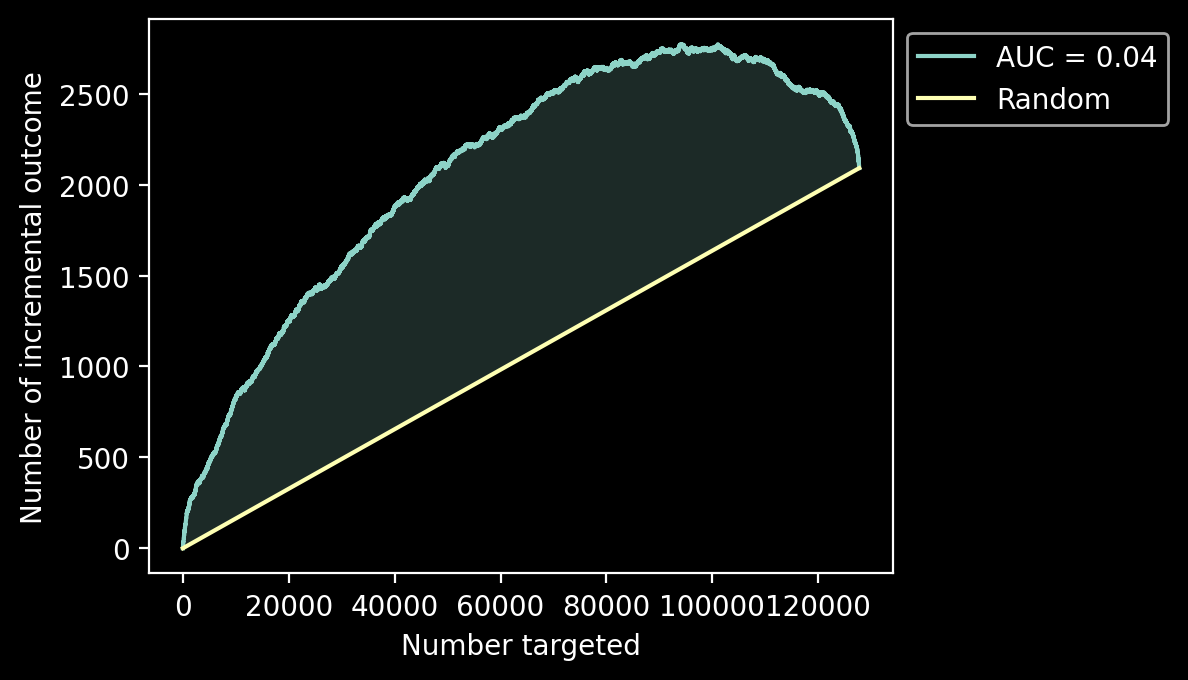

In [19]:
plot_qini_curve(train[y],uplift_train,train[T],perfect=False)

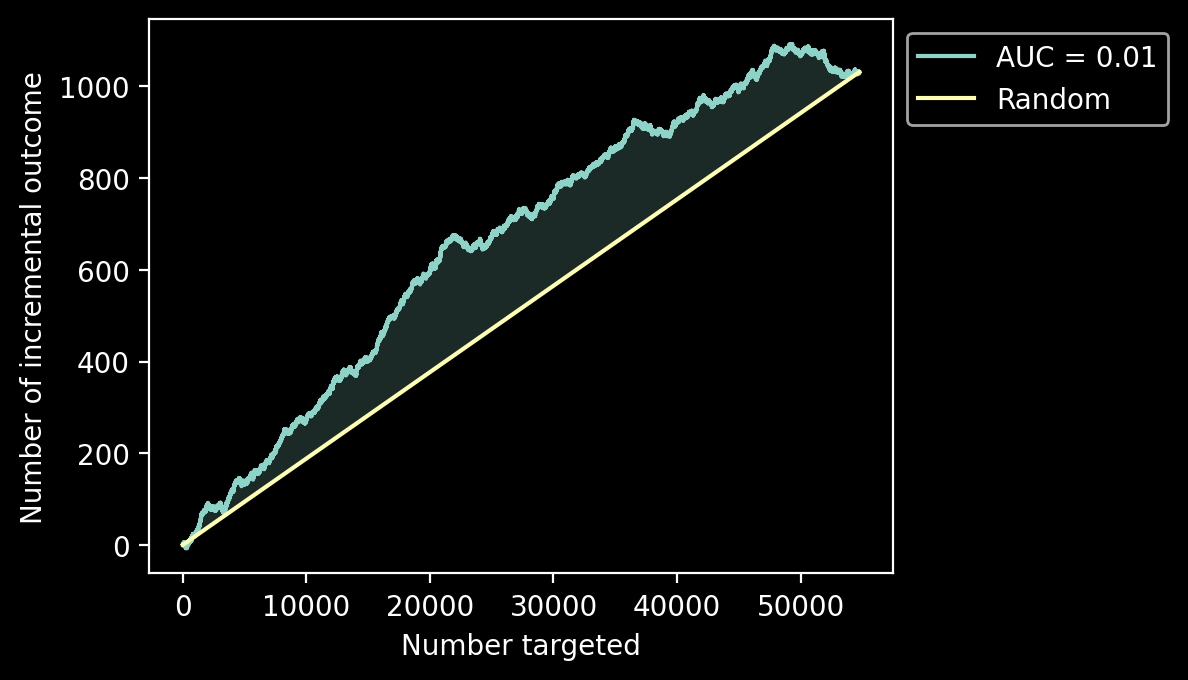

In [20]:
plot_qini_curve(test[y],uplift_test,test[T],perfect=False)